# 目的
- 購入者の効果、貢献度を評価する

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

import ChocoUtils as util

In [2]:
# jupyterの日本語設定
import matplotlib
from matplotlib.font_manager import FontProperties

font_path = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

# データロード

In [3]:
db_file = '../data/choco-ball.db'
f_str = 'campaign is not 1'
p_data = util.get_data(db_file=db_file, filter_str=f_str)
data = p_data.drop(columns='shop')
data[:3]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1;
Shape of MeasurementData(record_num, n_columns) : (40, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,angel,campaign,taste,buyer,net_weight,mean_weight
0,2017-12-04,2018-02-01,BA6,34.513,4.710,16,小山工場,0,2,0,根本,29.803,1.862688
1,2017-12-04,2018-02-01,AA6,33.644,4.731,16,小山工場,0,2,0,根本,28.913,1.807062
2,2017-12-10,2018-09-01,CA9,31.103,4.776,15,小山工場,0,2,1,時田,26.327,1.755133


In [4]:
# 銀のエンゼルのフラグデータ
data['silver'] = [1 if a == 1 else 0 for a in data['angel'].values]
# 金のエンゼル
data['gold'] = [1 if a == 2 else 0 for a in data['angel'].values]

# 購入者の調整
data['buyer'] = ['ピシャイ' if a in 'ピシャイ/佐藤' else a for a in data['buyer'].values]

data['buyer'] = ['筆者' if a in '時田' else a for a in data['buyer'].values]
data['buyer'] = ['同僚A' if a in '西田' else a for a in data['buyer'].values]
data['buyer'] = ['同僚B' if a in 'ピシャイ' else a for a in data['buyer'].values]
data['buyer'] = ['同僚C' if a in '根本' else a for a in data['buyer'].values]
data['buyer'] = ['同僚D' if a in '大谷' else a for a in data['buyer'].values]

data['ones'] = 1

In [5]:
data.pivot_table(index=['buyer'], columns=['angel'], values='ones', fill_value=0, aggfunc=lambda x:len(x))

angel,0,1
buyer,,
同僚A,8,0
同僚B,5,1
同僚C,2,0
同僚D,2,0
筆者,21,1


# 購入者別のエンゼル出現確率

In [6]:
import pymc as pm
import scipy.stats as stats

In [7]:
def getMCMCResult(data, n_sample=15000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Uniform('p', lower=0, upper=1)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)

    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)

    return mcmc.trace('p')[:]

 [-----------------100%-----------------] 15000 of 15000 complete in 0.6 sec

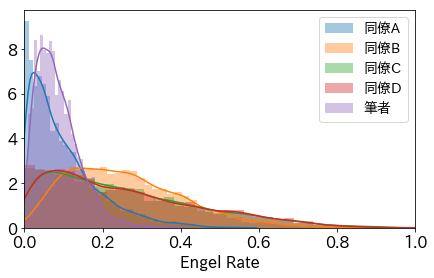

In [8]:
grp = data[data['campaign'] != 1].groupby(['buyer'])
g_cnt = len(grp.groups.keys())

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

cnt = 0
for key, group in grp:
    p_dist_silver = pd.Series(getMCMCResult(group['silver']))
    sns.distplot(p_dist_silver, ax=ax, label=key)
    cnt+=1
ax.legend(fontsize=14)
ax.set_xlabel('Engel Rate', fontsize=16)
ax.set_xlim([0.0, 1.0])
ax.tick_params(labelsize=16)

fig.savefig('./fig/estimate_angel_rate_buyer.png')

## β分布を事前分布に

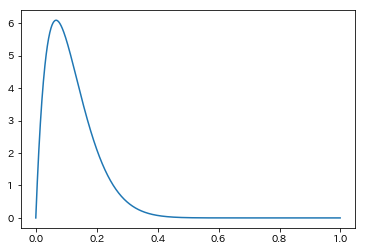

In [12]:
x = np.linspace(0.0, 0.999, 1000)
y = stats.beta.pdf(x, 2, 15)
plt.plot(x, y)
pd.DataFrame({'x':x, 'y':y}).sort_values(by=['y'], ascending=False)[:3]

#plt.savefig('./fig/beta_dist.png')

In [10]:
def getMCMCResultBeta(data, n_sample=15000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Beta('p', alpha=2, beta=15)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)

    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)

    return mcmc.trace('p')[:]

 [-----------------100%-----------------] 15000 of 15000 complete in 0.6 sec

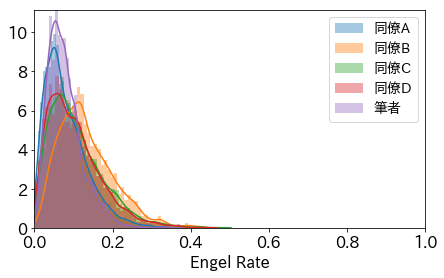

In [11]:
grp = data[data['campaign'] != 1].groupby(['buyer'])

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

for key, group in grp:
    p_dist_silver = pd.Series(getMCMCResultBeta(group['silver']))
    sns.distplot(p_dist_silver, ax=ax, label=key)
ax.legend(fontsize=14)
ax.set_xlabel('Engel Rate', fontsize=16)
ax.set_xlim([0.0, 1.0])
ax.tick_params(labelsize=16)

fig.savefig('./fig/estimate_angel_rate_buyer_beta.png')